<a href="https://colab.research.google.com/github/JaniVarga/Skin_detection/blob/main/Sematic_Segmentation_lraspp_mobilenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
from torchvision.models import segmentation

In [60]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [61]:
lraspp_mobilnet_v3_large = segmentation.lraspp_mobilenet_v3_large()

In [62]:
try:
  import torchinfo

except:
  print("Install torchinfo...")
  !pip --quiet install torchinfo
  import torchinfo
  print("Torchinfo is installed and import.")

else:
  print("torchinfo is already installed.")

torchinfo is already installed.


In [63]:
torchinfo.summary(model=lraspp_mobilnet_v3_large,
                  input_size=(1,3,224,224),
                  col_names=["input_size", "output_size", "trainable"],
                  row_settings=["var_names"],
                  col_width= 20
                  )

Layer (type (var_name))                                      Input Shape          Output Shape         Trainable
LRASPP (LRASPP)                                              [1, 3, 224, 224]     [1, 21, 224, 224]    True
├─IntermediateLayerGetter (backbone)                         [1, 3, 224, 224]     [1, 960, 14, 14]     True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 16, 112, 112]    True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 16, 112, 112]    True
│    │    └─BatchNorm2d (1)                                  [1, 16, 112, 112]    [1, 16, 112, 112]    True
│    │    └─Hardswish (2)                                    [1, 16, 112, 112]    [1, 16, 112, 112]    --
│    └─InvertedResidual (1)                                  [1, 16, 112, 112]    [1, 16, 112, 112]    True
│    │    └─Sequential (block)                               [1, 16, 112, 112]    [1, 16, 112, 112]    True
│    └─InvertedResidual (

In [64]:
lraspp_mobilnet_v3_large.classifier

LRASPPHead(
  (cbr): Sequential(
    (0): Conv2d(960, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (scale): Sequential(
    (0): AdaptiveAvgPool2d(output_size=1)
    (1): Conv2d(960, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): Sigmoid()
  )
  (low_classifier): Conv2d(40, 21, kernel_size=(1, 1), stride=(1, 1))
  (high_classifier): Conv2d(128, 21, kernel_size=(1, 1), stride=(1, 1))
)

In [65]:
# https://pytorch.org/vision/2.0/_modules/torchvision/models/segmentation/lraspp.html

from typing import Any, Dict, Optional
from torch import nn, Tensor
from torch.nn import functional as F

class new_head(nn.Module):
  def __init__(self):
    super().__init__()
    self.cbr = nn.Sequential(nn.Conv2d(in_channels=960, out_channels=128, kernel_size=1, stride=1, bias=False),
                            nn.BatchNorm2d(num_features=128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                            nn.ReLU(inplace=True)
                            )
    self.scale = nn.Sequential(nn.AdaptiveAvgPool2d(output_size=1),
                          nn.Conv2d(in_channels=960, out_channels=128, kernel_size=1, stride=1, bias=False),
                          nn.Sigmoid()
                          )
    self.low_classifier = nn.Conv2d(in_channels=40, out_channels=1, kernel_size=1, stride=1, bias=True)
    self.high_classifier = nn.Conv2d(in_channels=128, out_channels=1, kernel_size=1, stride=1, bias=True)

  def forward(self, input: Dict[str, Tensor]) -> Tensor:
    low = input["low"]
    high = input["high"]

    x = self.cbr(high)
    s = self.scale(high)
    x = x * s
    x = F.interpolate(x, size=low.shape[-2:], mode="bilinear", align_corners=False)

    return self.low_classifier(low) + self.high_classifier(x)

In [66]:
new_head = new_head()

In [67]:
lraspp_mobilnet_v3_large.classifier = new_head

In [68]:
torchinfo.summary(model=lraspp_mobilnet_v3_large,
                  input_size=(1,3,224,224),
                  col_names=["input_size", "output_size", "trainable"],
                  row_settings=["var_names"],
                  col_width= 20
                  )

Layer (type (var_name))                                      Input Shape          Output Shape         Trainable
LRASPP (LRASPP)                                              [1, 3, 224, 224]     [1, 1, 224, 224]     True
├─IntermediateLayerGetter (backbone)                         [1, 3, 224, 224]     [1, 960, 14, 14]     True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 16, 112, 112]    True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 16, 112, 112]    True
│    │    └─BatchNorm2d (1)                                  [1, 16, 112, 112]    [1, 16, 112, 112]    True
│    │    └─Hardswish (2)                                    [1, 16, 112, 112]    [1, 16, 112, 112]    --
│    └─InvertedResidual (1)                                  [1, 16, 112, 112]    [1, 16, 112, 112]    True
│    │    └─Sequential (block)                               [1, 16, 112, 112]    [1, 16, 112, 112]    True
│    └─InvertedResidual (

In [69]:
lraspp_mobilnet_v3_large.backbone["0"]

Conv2dNormActivation(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
  (2): Hardswish()
)

In [70]:
weights = segmentation.LRASPP_MobileNet_V3_Large_Weights.DEFAULT
auto_transform = weights.transforms()
auto_transform.describe()

'Accepts ``PIL.Image``, batched ``(B, C, H, W)`` and single ``(C, H, W)`` image ``torch.Tensor`` objects. The images are resized to ``resize_size=[520]`` using ``interpolation=InterpolationMode.BILINEAR``. Finally the values are first rescaled to ``[0.0, 1.0]`` and then normalized using ``mean=[0.485, 0.456, 0.406]`` and ``std=[0.229, 0.224, 0.225]``.'

In [71]:
from torchvision.transforms import v2
import torch

my_transform = v2.Compose([
      v2.ToImage(),
      v2.Resize(size=(224,224)),
      v2.ToDtype(torch.float32, scale=True),
      v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

my_transform

Compose(
      ToImage()
      Resize(size=[224, 224], interpolation=InterpolationMode.BILINEAR, antialias=True)
      ToDtype(scale=True)
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
)

In [72]:
from pathlib import Path

zip_file_path = Path("/content/dataset.zip")
root_path = Path("/content")

In [73]:
from zipfile import ZipFile

try:
  with ZipFile(file=zip_file_path) as zip_file:
      zip_file.extractall(path=root_path)
      print("File extracted.")

except FileNotFoundError:
  print("File not found.")

File not found.


In [74]:
try:
  zip_file_path.unlink()
  print("File deleted.")

except FileNotFoundError:
  print("File not found.")

File not found.


In [75]:
train_root_path = root_path / "dataset" / "train"
val_root_path = root_path / "dataset" / "val"

In [76]:
train_root_path, val_root_path

(PosixPath('/content/dataset/train'), PosixPath('/content/dataset/val'))

In [77]:
from torch.utils.data import Dataset
from glob import glob
from PIL import Image

class CustomDataset(Dataset):
  def __init__(self, root_dir: str, transform=None):
    self.root_dir = root_dir
    self.transform = transform
    self.images = sorted(glob(f"{root_dir}/images/*.*"))
    self.masks = sorted(glob(f"{root_dir}/masks/*.*"))

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    image = Image.open(self.images[idx])
    mask = Image.open(self.masks[idx])

    mask_transform = v2.Compose([
          v2.ToImage(),
          v2.Resize(size=(224,224))])


    if self.transform:
      image = self.transform(image)
      mask = mask_transform(mask)


    return image, mask

In [78]:
train_dataset = CustomDataset(root_dir=train_root_path, transform=my_transform)
val_dataset = CustomDataset(root_dir=val_root_path, transform=my_transform)
train_dataset, val_dataset

(<__main__.CustomDataset at 0x7946f3b567d0>,
 <__main__.CustomDataset at 0x7946f3b55f00>)

In [79]:
img, mask = train_dataset.__getitem__(0)

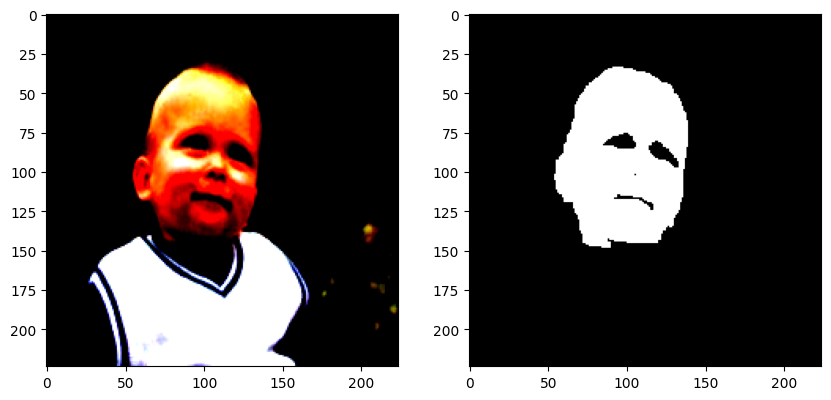

In [80]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].imshow(img.permute(1,2,0))
ax[1].imshow(mask.permute(1,2,0), cmap="gray")

In [81]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=16, shuffle=False)
train_dataloader, val_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7946f3b32bc0>,
 <torch.utils.data.dataloader.DataLoader at 0x7946f3b55060>)

In [82]:
# def dice_coefficient(prediction, target, epsilon=1e-07):
#     prediction_copy = prediction.clone()

#     prediction_copy[prediction_copy < 0] = 0
#     prediction_copy[prediction_copy > 0] = 1

#     intersection = abs(torch.sum(prediction_copy * target))
#     union = abs(torch.sum(prediction_copy) + torch.sum(target))
#     dice = (2. * intersection + epsilon) / (union + epsilon)

#     return dice

In [83]:
# https://smp.readthedocs.io/en/latest/_modules/segmentation_models_pytorch/losses/mcc.html#MCCLoss

import torch
from torch.nn.modules.loss import _Loss

class MCCLoss(_Loss):
    def __init__(self, eps: float = 1e-5):
        """Compute Matthews Correlation Coefficient Loss for image segmentation task.
        It only supports binary mode.

        Args:
            eps (float): Small epsilon to handle situations where all the samples in the dataset belong to one class

        Reference:
            https://github.com/kakumarabhishek/MCC-Loss
        """
        super().__init__()
        self.eps = eps

    def forward(self, y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
        """Compute MCC loss

        Args:
            y_pred (torch.Tensor): model prediction of shape (N, H, W) or (N, 1, H, W)
            y_true (torch.Tensor): ground truth labels of shape (N, H, W) or (N, 1, H, W)

        Returns:
            torch.Tensor: loss value (1 - mcc)
        """

        bs = y_true.shape[0]

        y_true = y_true.view(bs, 1, -1)
        y_pred = y_pred.view(bs, 1, -1)

        tp = torch.sum(torch.mul(y_pred, y_true)) + self.eps
        tn = torch.sum(torch.mul((1 - y_pred), (1 - y_true))) + self.eps
        fp = torch.sum(torch.mul(y_pred, (1 - y_true))) + self.eps
        fn = torch.sum(torch.mul((1 - y_pred), y_true)) + self.eps

        numerator = torch.mul(tp, tn) - torch.mul(fp, fn)
        denominator = torch.sqrt(
            torch.add(tp, fp)
            * torch.add(tp, fn)
            * torch.add(tn, fp)
            * torch.add(tn, fn)
        )

        mcc = torch.div(numerator.sum(), denominator.sum())
        loss = 1.0 - mcc

        return loss

In [84]:
try:
  import segmentation_models_pytorch as smp
except:
  print("Install segmentation_models_pytorch...")
  !pip --quiet install segmentation_models_pytorch
  import segmentation_models_pytorch as smp
  print("segmentation_models_pytorch is installed and import.")
else:
  print("segmentation_models_pytorch is already installed.")

segmentation_models_pytorch is already installed.


In [85]:
# https://smp.readthedocs.io/en/latest/losses.html


# optimizer = torch.optim.Adam(params=lraspp_mobilnet_v3_large.parameters(),
#                              lr=0.001)

loss_bce = nn.BCEWithLogitsLoss()
loss_mcc = MCCLoss()
loss_dice = smp.losses.DiceLoss(mode="binary", from_logits=True)

In [86]:
import numpy as np

np.random.seed(42)
torch.manual_seed(42)
model_1 = lraspp_mobilnet_v3_large.to(device)

In [87]:
from tqdm import tqdm

def train_model(name,
                loss_fn,
                model,
                optimizer,
                train_dataloader= train_dataloader,
                val_dataloader= val_dataloader,
                epochs=5):

  train_losses = []
  train_dcs = []
  val_losses = []
  val_dcs = []

  print(f"Start model training, loss_{name}")

  for epoch in tqdm(range(epochs)):
    model.train()
    train_running_loss = 0
    train_running_dc = 0

    for idx, img_mask in enumerate(tqdm(train_dataloader, position=0, leave=True)):
        img = img_mask[0].float().to(device)
        mask = img_mask[1].float().to(device)

        y_pred = model(img)["out"]

        if name == "mcc":
          y_pred = torch.sigmoid(y_pred)
        else:
          pass

        optimizer.zero_grad()
        # print(f"\n\n\nY_pred shape: {y_pred.shape}")
        # print(f"Mask shape: {mask.shape}\n\n\n")

        # dc = dice_coefficient(y_pred, mask)
        loss = loss_fn(y_pred, mask)

        train_running_loss += loss.item()
        # train_running_dc += dc.item()

        loss.backward()
        optimizer.step()

    train_loss = train_running_loss / (idx + 1)
    train_dc = train_running_dc / (idx + 1)

    train_losses.append(train_loss)
    train_dcs.append(train_dc)

    model.eval()
    val_running_loss = 0
    val_running_dc = 0

    with torch.no_grad():
        for idx, img_mask in enumerate(tqdm(val_dataloader, position=0, leave=True)):
            img = img_mask[0].float().to(device)
            mask = img_mask[1].float().to(device)

            y_pred = model(img)["out"]
            if name == "mcc":
              y_pred = torch.sigmoid(y_pred)
            else:
              pass

            loss = loss_fn(y_pred, mask)
            # dc = dice_coefficient(y_pred, mask)

            val_running_loss += loss.item()
            # val_running_dc += dc.item()

        val_loss = val_running_loss / (idx + 1)
        # val_dc = val_running_dc / (idx + 1)

    val_losses.append(val_loss)
    # val_dcs.append(val_dc)
    print("\n")
    print("-" * 30)
    print(f"Training {name} EPOCH {epoch + 1}: {train_loss:.4f}")
    # print(f"Training DICE EPOCH {epoch + 1}: {train_dc:.4f}")
    print(f"Validation {name} EPOCH {epoch + 1}: {val_loss:.4f}")
    # print(f"Validation DICE EPOCH {epoch + 1}: {val_dc:.4f}")


    # Saving the best model
    if val_loss == min(val_losses):
        print("Saving the model...")
        torch.save(model.state_dict(), f'my_best_checkpoint_{name}.pth')
    print("-" * 30)

  return train_losses, val_losses

In [88]:
optimizer_1 = torch.optim.Adam(params=model_1.parameters(),
                             lr=0.001)

mcc_train_losses, mcc_val_losses = train_model("mcc", loss_mcc, model_1, optimizer_1)

Start model training, loss_mcc


 20%|██        | 1/5 [11:22<45:28, 682.09s/it]



------------------------------
Training mcc EPOCH 1: 0.2387
Validation mcc EPOCH 1: 0.1480
Saving the model...
------------------------------


 40%|████      | 2/5 [22:38<33:56, 678.68s/it]



------------------------------
Training mcc EPOCH 2: 0.1299
Validation mcc EPOCH 2: 0.1278
Saving the model...
------------------------------


 60%|██████    | 3/5 [33:55<22:35, 678.00s/it]



------------------------------
Training mcc EPOCH 3: 0.1140
Validation mcc EPOCH 3: 0.1133
Saving the model...
------------------------------


 80%|████████  | 4/5 [45:04<11:14, 674.37s/it]



------------------------------
Training mcc EPOCH 4: 0.0988
Validation mcc EPOCH 4: 0.1136
------------------------------


100%|██████████| 5/5 [56:19<00:00, 675.84s/it]



------------------------------
Training mcc EPOCH 5: 0.0933
Validation mcc EPOCH 5: 0.1080
Saving the model...
------------------------------


In [89]:
lraspp_mobilnet_v3_large = segmentation.lraspp_mobilenet_v3_large()
lraspp_mobilnet_v3_large.classifier = new_head

model_2 = lraspp_mobilnet_v3_large.to(device)
optimizer_2 = torch.optim.Adam(params=model_2.parameters(),
                             lr=0.001)
dice_train_losses,  dice_val_losses = train_model("dice", loss_dice, model_2, optimizer_2)

Start model training, loss_dice


 20%|██        | 1/5 [11:22<45:30, 682.56s/it]



------------------------------
Training dice EPOCH 1: 0.1403
Validation dice EPOCH 1: 0.1096
Saving the model...
------------------------------


 40%|████      | 2/5 [22:36<33:51, 677.32s/it]



------------------------------
Training dice EPOCH 2: 0.0941
Validation dice EPOCH 2: 0.0889
Saving the model...
------------------------------


 60%|██████    | 3/5 [33:51<22:32, 676.47s/it]



------------------------------
Training dice EPOCH 3: 0.0839
Validation dice EPOCH 3: 0.0809
Saving the model...
------------------------------


 80%|████████  | 4/5 [45:13<11:18, 678.48s/it]



------------------------------
Training dice EPOCH 4: 0.0771
Validation dice EPOCH 4: 0.0819
------------------------------


100%|██████████| 5/5 [56:34<00:00, 678.89s/it]



------------------------------
Training dice EPOCH 5: 0.0759
Validation dice EPOCH 5: 0.0760
Saving the model...
------------------------------


In [90]:
lraspp_mobilnet_v3_large = segmentation.lraspp_mobilenet_v3_large()
lraspp_mobilnet_v3_large.classifier = new_head

model_3 = lraspp_mobilnet_v3_large.to(device)
optimizer_3 = torch.optim.Adam(params=model_3.parameters(),
                             lr=0.001)
bce_train_losses,  bce_val_losses = train_model("bce", loss_bce, model_3, optimizer_3)

Start model training, loss_bce


 20%|██        | 1/5 [11:48<47:12, 708.06s/it]



------------------------------
Training bce EPOCH 1: 0.1693
Validation bce EPOCH 1: 0.1486
Saving the model...
------------------------------


 40%|████      | 2/5 [23:17<34:51, 697.02s/it]



------------------------------
Training bce EPOCH 2: 0.0961
Validation bce EPOCH 2: 0.1059
Saving the model...
------------------------------


 60%|██████    | 3/5 [34:39<23:00, 690.11s/it]



------------------------------
Training bce EPOCH 3: 0.0814
Validation bce EPOCH 3: 0.0983
Saving the model...
------------------------------


 80%|████████  | 4/5 [46:07<11:29, 689.36s/it]



------------------------------
Training bce EPOCH 4: 0.0721
Validation bce EPOCH 4: 0.0891
Saving the model...
------------------------------


100%|██████████| 5/5 [57:43<00:00, 692.63s/it]



------------------------------
Training bce EPOCH 5: 0.0655
Validation bce EPOCH 5: 0.0969
------------------------------


In [91]:
def visualize_results(mcc_losses_train,
                      mcc_losses_val,
                      dice_losses_train,
                      dice_losses_val,
                      bce_loss_train, bce_losses_val):

  fig, ax = plt.subplots(1,3, figsize=(10,5))

  ax[0].plot(mcc_losses_train, label="Train MCC Loss")
  ax[0].plot(mcc_losses_val, label="Val MCC Loss")
  ax[0].legend()
  ax[0].set_title("MCC Loss")

  ax[1].plot(dice_losses_train, label="Train DICE Loss")
  ax[1].plot(dice_losses_val, label="Val DICE Loss")
  ax[1].legend()
  ax[1].set_title("DICE Loss")

  ax[2].plot(bce_loss_train, label="Train BCE Loss")
  ax[2].plot(bce_losses_val, label="Val BCE Loss")
  ax[2].legend()
  ax[2].set_title("BCE Loss")

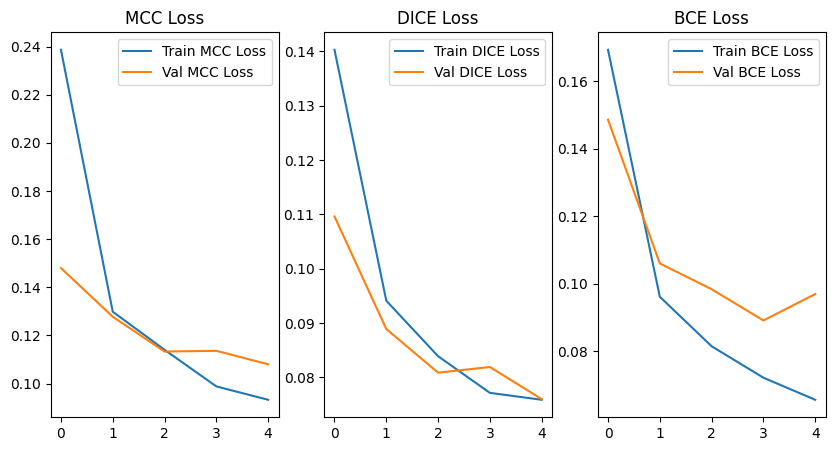

In [92]:
visualize_results(mcc_train_losses,
                  mcc_val_losses,
                  dice_train_losses,
                  dice_val_losses,
                  bce_train_losses,  bce_val_losses )

In [93]:
def show_result(best_model_path, model):

  test_img_path = "/content/1728293261557.jpeg"
  test_img = Image.open(test_img_path)
  test_img = my_transform(test_img).unsqueeze(0).to(device)

  model = model
  model.load_state_dict(torch.load(best_model_path, weights_only=True))
  model.eval()

  model.eval()
  with torch.inference_mode():
      y_logits = model(test_img)["out"]
      y_pred = torch.round(torch.sigmoid(y_logits))

  pred_mask = y_pred.to("cpu").squeeze()

  plt.imshow(pred_mask)

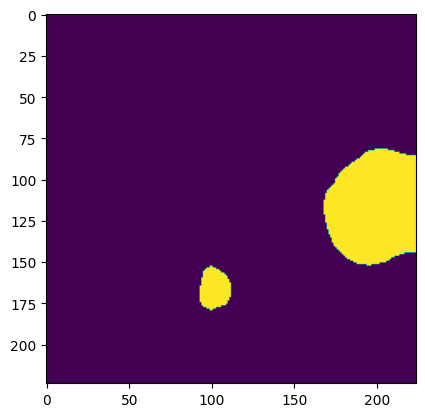

In [94]:
show_result("my_best_checkpoint_mcc.pth", model_1)

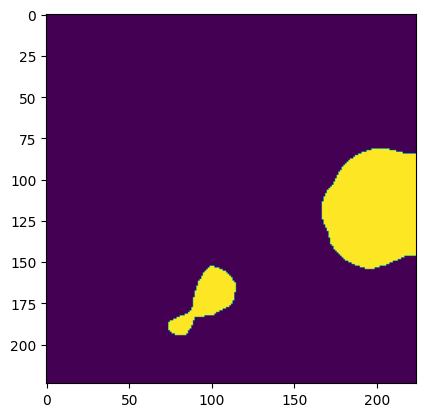

In [95]:
show_result("my_best_checkpoint_dice.pth", model_2)

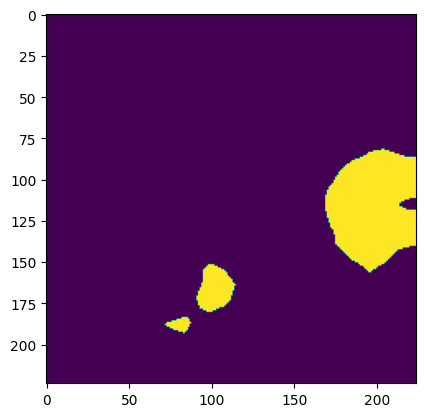

In [96]:
show_result("my_best_checkpoint_bce.pth", model_3)